In [87]:
import sys
import os
import os.path as op
# from dipy.io.image import load_nifti
import nibabel as nib
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import torchvision
from torch.utils.data import DataLoader, SubsetRandomSampler
import torchio as tio
import numpy as np
# import pytorch_lightning as pl
import pandas as pd
import seaborn as sns
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline

In [2]:
data_path = op.join(sys.path[0], '../../Experiment4/sub-01/mfmri.nii.gz')

In [3]:
img = tio.ScalarImage(data_path)
img

ScalarImage(shape: (360, 144, 48, 27); spacing: (0.97, 0.97, 3.00); orientation: LAS+; path: "/home/tim/OneDrive/Studium M. Sc/EPFL/Project/dev/SpinalcordSeg/../../Experiment4/sub-01/mfmri.nii.gz")

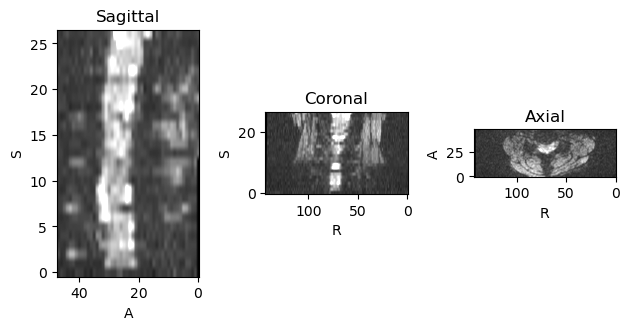

In [4]:
img.plot()

In [5]:
label_path = op.join(sys.path[0], '../../Experiment4/sub-01/mask_sc.nii.gz')

In [6]:
label = tio.LabelMap(label_path)
label

LabelMap(shape: (1, 144, 48, 27); spacing: (0.97, 0.97, 3.00); orientation: LAS+; path: "/home/tim/OneDrive/Studium M. Sc/EPFL/Project/dev/SpinalcordSeg/../../Experiment4/sub-01/mask_sc.nii.gz")

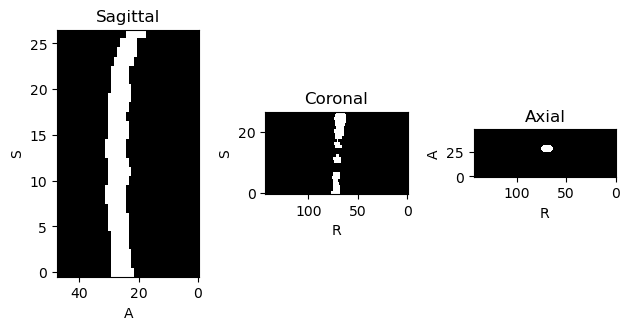

In [7]:
label.plot()

In [80]:
motion_param = {}
for i in range(1, 20):
    motion_param[f'sub{i}'] = pd.read_csv(f'../../Experiment4/sub-{i:02d}/motion_xy.txt', sep=" ", names=['x', 'y', 'remove'])[['x', 'y']]
    motion_param[f'sub{i}']['Volume'] = range(1,361)
    motion_param[f'sub{i}']['subject'] = f'sub{i}'
    
motion_param[f'sub21'] = pd.read_csv(f'../../Experiment4/sub-21/motion_xy.txt', sep=" ", names=['x', 'y', 'remove'])[['x', 'y']]

for i in motion_param.keys():
    motion_param[i]['Volume'] = range(1,361)
    motion_param[i]['subject'] = i

In [85]:
overall = pd.concat(motion_param.values())
overall

,x,y,Volume,subject
0,0.000000,0.000000,1,sub1
1,0.048104,0.133932,2,sub1
2,0.046358,0.186349,3,sub1
3,0.065004,0.247594,4,sub1
4,0.046905,0.077291,5,sub1
...,...,...,...,...
355,0.417137,0.879837,356,sub21
356,0.463591,0.582148,357,sub21
357,0.441066,0.778352,358,sub21
358,0.384013,0.891708,359,sub21


[Text(0.5, 0, 'subjects'),
 Text(0, 0.5, 'motion in y direction'),
 Text(0.5, 1.0, 'Motion in Y Direction')]

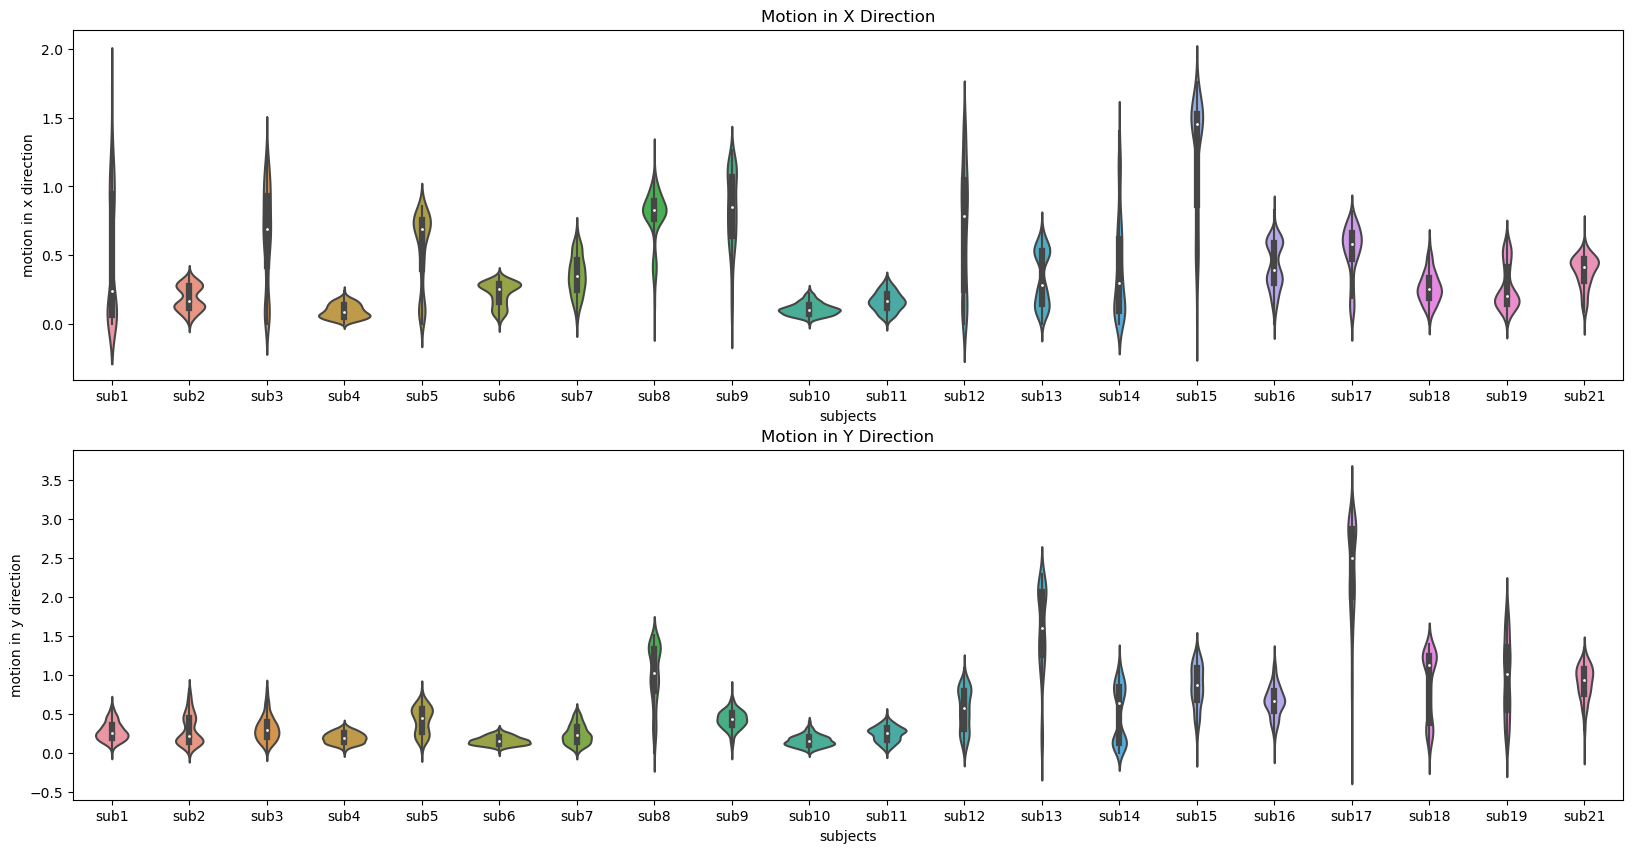

In [95]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
gx = sns.violinplot(data=overall, x='subject', y='x', ax=ax[0])
gx.set(xlabel='subjects', ylabel='motion in x direction', title='Motion in X Direction')

gy = sns.violinplot(data=overall, x='subject', y='y', ax=ax[1])
gy.set(xlabel='subjects', ylabel='motion in y direction', title='Motion in Y Direction')

[Text(0.5, 0, 'subjects'),
 Text(0, 0.5, 'motion in y direction'),
 Text(0.5, 1.0, 'Motion in Y Direction')]

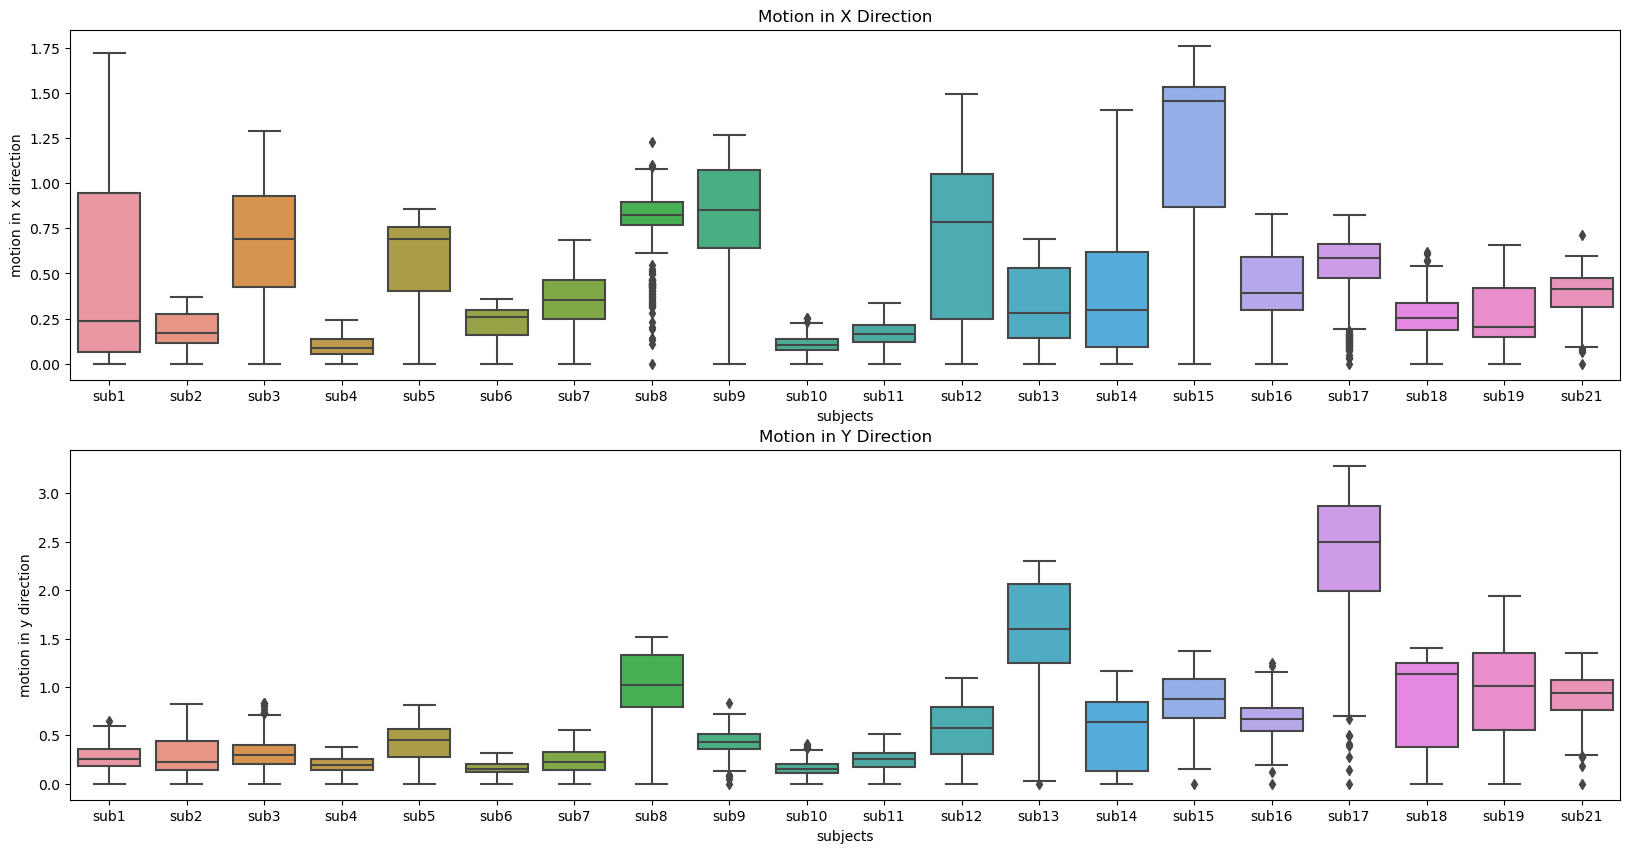

In [97]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
gx = sns.boxplot(data=overall, x='subject', y='x', ax=ax[0])
gx.set(xlabel='subjects', ylabel='motion in x direction', title='Motion in X Direction')

gy = sns.boxplot(data=overall, x='subject', y='y', ax=ax[1])
gy.set(xlabel='subjects', ylabel='motion in y direction', title='Motion in Y Direction')

Subjects with largest amplitude are: sub1, sub3, sub5, sub7, sub8, sub9, sub12, sub13, sub14, sub15, sub16, sub17, sub18, sub19, sub21

This leaves us with: sub2, sub4, sub6, sub10, sub11

In [101]:
mask = overall['subject'].isin(['sub2', 'sub4', 'sub6', 'sub10', 'sub11'])
filtered_overall = overall[mask]

Now calculating framewise displacement

In [102]:
def compute_FD_power(mot_params):
    framewise_diff = mot_params.diff().iloc[1:]
    trans_params = framewise_diff[['x', 'y']]
    fd = trans_params.abs().sum(axis=1)
    return fd

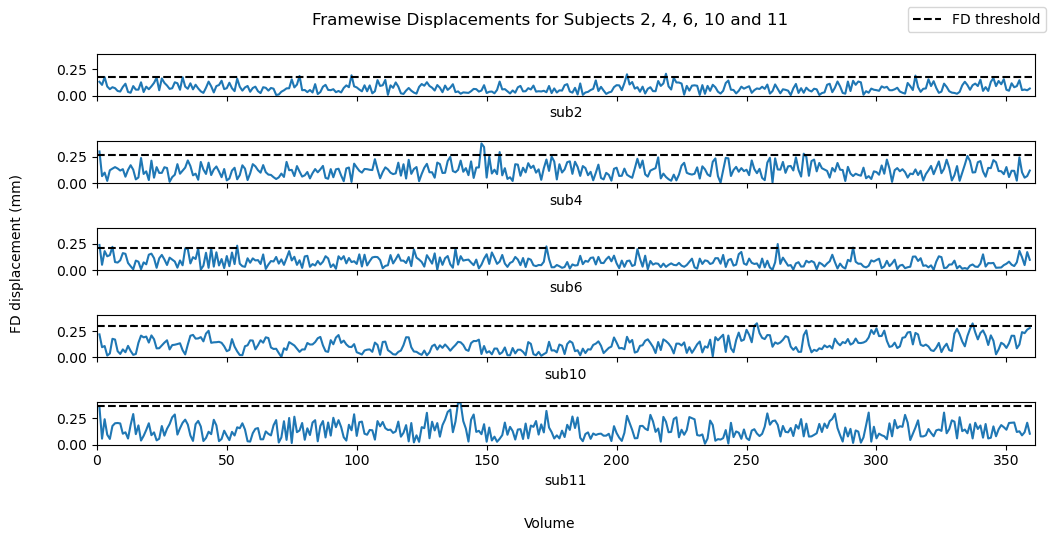

In [164]:
fig, ax = plt.subplots(filtered_overall['subject'].nunique(), 1, figsize=(10, 5), sharex=True)

for index, key in enumerate(filtered_overall['subject'].unique()):
    fd = compute_FD_power(filtered_overall[filtered_overall['subject'].isin([key])][['x', 'y']]).to_numpy()
    threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))
    ax[index].plot(list(range(1, fd.size+1)), fd, label='_nolegend_')
    ax[index].set_xlim(left=0, right=361)
    ax[index].set_ylim(bottom=0, top=0.4)
    ax[index].hlines(threshold, 0, 360,colors='black', linestyles='dashed', label='FD threshold')
    ax[index].set_xlabel(key)

fig.text(0.5, -0.05, 'Volume', ha='center', rotation='horizontal')
fig.suptitle('Framewise Displacements for Subjects 2, 4, 6, 10 and 11')
fig.text(-0.04, 0.5, 'FD displacement (mm)', va='center', rotation='vertical')
fig.legend(['FD threshold'])
plt.tight_layout()

In [171]:
for index, key in enumerate(filtered_overall['subject'].unique()):
    fd = compute_FD_power(filtered_overall[filtered_overall['subject'].isin([key])][['x', 'y']]).to_numpy()
    threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))
    print(f'Motion Outliers for {key}:', np.where(fd > threshold)[0] + 1)
    print(f'Threshold for {key}: {threshold}')

Motion Outliers for sub2: [ 78  98 204 219 315]
Threshold for sub2: 0.17990999999999996
Motion Outliers for sub4: [  1 148 149 155 272]
Threshold for sub4: 0.26348375
Motion Outliers for sub6: [  1   6  54 173 262 291]
Threshold for sub6: 0.20878175000000002
Motion Outliers for sub10: [253 254 337]
Threshold for sub10: 0.29768675
Motion Outliers for sub11: [139 140]
Threshold for sub11: 0.3631835


Subject 2 will be chosen as the threshold is much lower. Setting the treshold to the one of subject 6 which is the second smallest, results in no 'outlier'.

In [173]:
fd = compute_FD_power(filtered_overall[filtered_overall['subject'].isin(['sub2'])][['x', 'y']]).to_numpy()
# threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))
threshold = 0.2087
print(f'Motion Outliers for sub2:', np.where(fd > threshold)[0] + 1)
print(f'Threshold for sub2: {threshold}')

Motion Outliers for sub2: []
Threshold for sub2: 0.2087


## FSLeyes

In [9]:
load('../../Experiment4/sub-01/mfmri.nii.gz')

Image(mfmri, /home/tim/OneDrive/Studium M. Sc/EPFL/Project/Experiment4/sub-01/mfmri.nii.gz)

In [10]:
load('../../Experiment4/sub-01/mask_sc.nii.gz')

Image(mask_sc, /home/tim/OneDrive/Studium M. Sc/EPFL/Project/Experiment4/sub-01/mask_sc.nii.gz)